In [2]:
import geopandas as gpd
import pandas as pd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:

### Sampleo "Pesado" de Censo, para poder tener buena calidad en areas pequenas.

### Prediccion en base a modelos. Ultimos 4 trimestres disponibles.

### Generar dataset de pobreza


In [4]:

from datetime import datetime
hoy = datetime.today().strftime('%Y-%m-%d')
hoy

'2022-09-14'

# 1. Sampleo Censo

In [5]:
import datetime as dt
## Trimestres con ingresos disponibles (depende de disponibilidad de microdatos EPH)
import glob

fuente_modelos = 'encuestador-de-hogares' # 
modelos_trimestrales = '/media/miglesia/Elements/suite/'+fuente_modelos+'/fitted_RF/clf4_' # use your path

allFiles = []
allFiles += glob.glob(modelos_trimestrales +'*'+'ARG')
allFiles = sorted(allFiles)
FilesActual = allFiles[-4:]
FilesActual

['/media/miglesia/Elements/suite/encuestador-de-hogares/fitted_RF/clf4_2021-05-15_ARG',
 '/media/miglesia/Elements/suite/encuestador-de-hogares/fitted_RF/clf4_2021-08-15_ARG',
 '/media/miglesia/Elements/suite/encuestador-de-hogares/fitted_RF/clf4_2021-11-15_ARG',
 '/media/miglesia/Elements/suite/encuestador-de-hogares/fitted_RF/clf4_2022-02-15_ARG']

In [6]:
import numpy as np
from pathlib import Path

qstrings = np.unique([Path(f).name.split('_')[-2] for f in  FilesActual])
ystrings = np.unique([Path(f).name.split('_')[-2].split('-')[0] for f in  FilesActual])
yrs = [int(y) for y in ystrings]

startyr = min(yrs)
endyr = max(yrs) + 1

In [7]:
import os

if not os.path.exists('./../../samplerCensoARG/'):
    !git clone https://github.com/matuteiglesias/samplerCensoARG.git ./../../

In [8]:
frac = 0.02 ## Frac needs to be the fraction used in the sampling (eg. -f 0.01 needs frac = 0.01)

sample_tag = 'CSactual'

# Comentar si los datasets ya estan calculados
# for j in range(2):
#     sample_tag = str(10*j).zfill(3)
#     print(sample_tag)
    
# !python ./../../samplerCensoARG/samplear.py -dbp '/media/miglesia/Elements/suite/ext_CPV2010_basico_radio_pub' -f $frac -y $startyr $endyr -n $sample_tag


In [8]:

AGLO_rk = pd.read_csv('./../../encuestador-de-hogares/data/info/AGLO_rk')
rk_table = AGLO_rk.set_index(['ANO4', 'AGLOMERADO']).unstack()
AGLO_rk_filled = rk_table.fillna(rk_table.mean()).stack().reset_index()
AGLO_rk = AGLO_rk_filled

Reg_rk = pd.read_csv('./../../encuestador-de-hogares/data/info/Reg_rk')

dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')

# for j in range(2):
#     sample_tag = str(10*j).zfill(3)
#     print(sample_tag)
    
for yr in [str(s) for s in range(startyr, endyr)]:
    print(yr)
    out_filename = '/media/miglesia/Elements/suite/yr_samples/table_f'+str(frac)+'_'+yr+'_'+sample_tag+'.csv'

    if not os.exists(out_filename):

        table = pd.read_csv('./../../samplerCensoARG/data/censo_samples/table_f'+str(frac)+'_'+yr+'_'+sample_tag+'.csv')
        table['ANO4'] = int(yr)

        # Adaptamos las categorias de respuestas para que iguales las de la EPH
        ## VIVIENDA
        table['V01'] = table['V01'].map({1:1, 2:6, 3:6, 4:2, 5:3, 6:4, 7:5, 8:6})
        ## HOGAR
        table['H06'] = table['H06'].map({1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:9})
        table['H09'] = table['H09'].map({1:1, 2:2, 3:3, 4:4, 5:4, 6:4})
        table['H16'] = table['H16'].clip(0, 9)
        table['H14'] = table['H14'].map({1:1, 2:4, 3:2, 4:2, 5:4, 6:3, 7:4, 8:9})
        table['H13'] = table['H13'].map({1:1, 2:2, 4:0})
        # PERSONA
        table['P07'] = table['P07'].map({1:1, 2:2, 0:2})

        ## Agregar Region
        table = table.merge(dpto_region[['DPTO', 'Region']])

        ## Agregar ranking de Region y Aglo
        print(table.shape)
        table = table.merge(AGLO_rk[['AGLOMERADO', 'ANO4', 'AGLO_rk']]).merge(Reg_rk[['Region', 'ANO4', 'Reg_rk']])
        print(table.shape)

        table.to_csv(out_filename, index = False)  # Copias en carpeta yr_samples, en nuestra carpeta de indice de pobreza


SyntaxError: invalid syntax (<ipython-input-8-42b8a69ce876>, line 18)

# 2. Predecir  (X --> y)

## Info Empleo

In [9]:
empleo = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/empleoARG/main/datos/45.2_ECTDT.csv')
empleo = empleo[['45.2_IT_0_T_13', '45.2_ECTDT_0_T_33']] # ('45.2_ECTDT_0_T_33' es tasa de desocupacion en total aglomerados)
empleo['Q'] = pd.to_datetime(empleo['45.2_IT_0_T_13']) + pd.DateOffset(months=1, days = 14)
empleo = empleo.set_index('Q').drop(['45.2_IT_0_T_13'], axis = 1)
empleo = empleo.replace('s/d', np.nan).astype(float).round(4)
empleo['censo2010_ratio'] = (empleo/empleo.loc['2010-11-15'])

## notar que la tasa en Aglos, segun el censo, no es igual al valor de la serie de tiempo.
# para oct 2010 el censo da (6.29 %) y la que tenemos en dato (7.5%)
desoc_C2010 = pd.read_csv('./../data/info/desoc_AGLOsi_C2010.csv')
tasa_C2010 = desoc_C2010.loc[desoc_C2010.AGLO_si == True]['Tasa desocupacion'].values[0]
tasa_C2010

0.0628729377307203

In [8]:
import json

### Funcion ajustar nivel de empleo

def ajustar_empleo(data, verbose = False):

        ratio = empleo.loc[pd.to_datetime(q)].censo2010_ratio
        n_desempleados_ = ratio*(CONDACT_cnts[1] + CONDACT_cnts[2])*tasa_C2010
        desemp_adic = round(n_desempleados_ - CONDACT_cnts.loc[2]) # Desempleados adicionales
        
        print(str(q)[:10])

        if desemp_adic > 0:
            data.loc[
                data.query('CONDACT == 1').sample(desemp_adic).index,
                'CONDACT'
            ] = 2
        elif desemp_adic < 0:
            data.loc[
                data.query('CONDACT == 2').sample(- desemp_adic).index,
                'CONDACT'
            ] = 1

        if verbose:
            desempleo = data.CONDACT.value_counts().loc[2] / (data.CONDACT.value_counts().loc[1] + data.CONDACT.value_counts().loc[2])
            print('desempleo:' + str(desempleo))
        
        return data
    
    
def predict_save(X_data, x_cols, y_cols, model_filename, out_filename, balance_proba, tag, overwrite = False):

        # Si todavia no existe la training data de ese anio, o si la opcion overwrite esta activada:
        if (not os.path.exists(out_filename)) or (overwrite): 

            CLF = joblib.load(model_filename)
            
            if balance_proba: ## Prediccion usando predict proba y factores de balance.
                y_out = pd.DataFrame([])
                proba_values = CLF.predict_proba(X_data[x_cols])

                ## Leer factores de archivo json
                with open('/home/miglesia/repositories/encuestador-de-hogares/data/training/factors/'+tag+'.json', 'r') as file:
                    info = json.load(file)
                factors_mean = pd.DataFrame(json.loads(info[tag])).stack()
                factors_mean.index.names = ['variable', 'valor']
                factors_mean.index = factors_mean.index.set_levels(factors_mean.index.levels[1].astype(float).astype(int), level='valor')

                for j, y_col in enumerate(y_cols):

                    y_probas = pd.DataFrame(proba_values[j], columns = factors_mean.loc[y_col].index.values)
                    y_out[y_col] = (y_probas/factors_mean.loc[y_col]).idxmax(1)#.value_counts().sort_index()
                
            else: ## Prediccion sin balance
                y_out = CLF.predict(X_data[x_cols].values)

            ## Listo
            y_censo_fit = pd.DataFrame(y_out, index = X_data.index, columns=y_cols)
            
            Xy_censo = pd.concat([X_data, y_censo_fit], axis = 1)

#             save
            Xy_censo.to_csv(out_filename, index = False)
            print('File saved at '+ out_filename)
            del X_data; del Xy_censo; del CLF
#             gc.collect()

In [9]:
overwrite = False

## Elegir el dataset usado como X:
frac = '0.02'

# models_path = '/media/miglesia/Elements/suite/estocasticidad_indice_pobreza'
models_path = '/media/miglesia/Elements/suite/encuestador-de-hogares'

balance_proba = False

import joblib

models_tag = 'ARG'
sample_tag = 'CSactual'

# for i in range(n_models):
#     models_tag = str(i).zfill(3)

#     for j in range(2):
#         sample_tag = str(10*j).zfill(3)
experiment_tag = models_tag + sample_tag

print(experiment_tag)

ARGCSactual


In [12]:


for yr in [str(s) for s in range(startyr, endyr)]:
    print(yr)
    file_ = '/media/miglesia/Elements/suite/yr_samples/table_f'+str(frac)+'_'+yr+'_'+sample_tag+'.csv'

    X_censo = pd.read_csv(file_, usecols = ['DPTO','RADIO_REF_ID','PERSONA_REF_ID', 'HOGAR_REF_ID','IX_TOT', 'P02', 'P03', 'CONDACT', 'AGLOMERADO', 'URP', 'V01', 'H05', 'H06',
           'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14', 'AGLO_rk', 'Reg_rk',
           'H13', 'P07', 'P08', 'P09', 'P10', 'P05']).fillna(0)

    ## Tratamiento trimestral 
#             qs = np.array(allqs)[[i for i, si in enumerate(allqs) if si.startswith(yr)]]
    qs = np.array(qstrings)[[i for i, si in enumerate(qstrings) if si.startswith(yr)]]
    print(qs)

    CONDACT_cnts = X_censo.CONDACT.value_counts()

#             print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

    ### Cargar modelos de la parte no trimestral (anual).
    for q in sorted(qs):

        ### AJUSTAR NIVEL DE DESEMPLEO
        X_q = X_censo.copy()
        X_q['Q'] = q
        print('Nuevo trimestre.')

        X_q = ajustar_empleo(X_q)

        #################################    #################################    #################################

        print('C1')
        ## CLASIF 1
        X_data = X_q;
        y_cols1 = ['CAT_OCUP', 'CAT_INAC', 'CH07']
        x_cols1 = ['IX_TOT', 'P02', 'P03', 'AGLO_rk', 'Reg_rk', 'V01', 'H05', 'H06',
       'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H16', 'H15', 'PROP', 'H14',
       'H13', 'P07', 'P08', 'P09', 'P10', 'P05', 'CONDACT']
        out_filename1 = '/media/miglesia/Elements/suite/yr_samples/RFC1_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

        predict_save(X_data,
                     x_cols = x_cols1,
                     y_cols = y_cols1,
                     out_filename = out_filename1,
                     model_filename = models_path + '/fitted_RF/clf1_'+yr+'_'+models_tag,
                     balance_proba = balance_proba,
                     tag = 'clf1_'+yr+'_'+models_tag,
                    overwrite = overwrite)

        del X_q; del X_data
#         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

        #################################    #################################    #################################

        print('C2')
        ## CLASIF 2
        X_data = pd.read_csv(out_filename1)
        y_cols2 = ['INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS']
        x_cols2 = x_cols1 + y_cols1
        out_filename2 = '/media/miglesia/Elements/suite/yr_samples/RFC2_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

        predict_save(X_data,
                     x_cols = x_cols2,
                     y_cols = y_cols2,
                     out_filename = out_filename2,
                     model_filename = models_path + '/fitted_RF/clf2_'+yr+'_'+models_tag,
                     balance_proba = balance_proba,
                     tag = 'clf2_'+yr+'_'+models_tag,
                    overwrite = overwrite)

        del X_data
#         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

        #################################    #################################    #################################

        print('C3')

        ## CLASIF 3
        X_data = pd.read_csv(out_filename2)
        y_cols3 = ['PP07G1','PP07G_59', 'PP07I', 'PP07J', 'PP07K']
        x_cols3 = x_cols2 + y_cols2
        out_filename3 = '/media/miglesia/Elements/suite/yr_samples/RFC3_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'

        predict_save(X_data,
                     x_cols = x_cols3,
                     y_cols = y_cols3,
                     out_filename = out_filename3,
                     model_filename = models_path + '/fitted_RF/clf3_'+yr+'_'+models_tag,
                     balance_proba = balance_proba,
                     tag = 'clf3_'+yr+'_'+models_tag,
                    overwrite = overwrite)
        del X_data
#         print(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:5])

        #################################    #################################    #################################


        # Columnas de ingresos. Necesitan una regresion...
        columnas_pesos = [u'P21', u'P47T', u'PP08D1', u'TOT_P12', u'T_VI', u'V12_M', u'V2_M', u'V3_M', u'V5_M']

        x_cols4 = x_cols3 + y_cols3
        # Columnas de ingresos. Necesitan una regresion...
        predecir4 = columnas_pesos
        y_cols4 = predecir4


        print('reg')
        # REGRESION            
        out_filename4 = '/media/miglesia/Elements/suite/yr_samples/RFReg_'+str(frac)+'_'+str(q)[:10]+'_'+experiment_tag+'.csv'
        if (not os.path.exists(out_filename4)) or (overwrite): 

            ## Cargar Modelo
            model_filename4 = models_path + '/fitted_RF/clf4_'+str(q)[:10]+'_'+models_tag
    #         filename = '/media/miglesia/Elements/CENSO_dirs/Pobreza/fitted_RF/clf4_0.02_'+str(q)[:10]+'_'+experiment_tag+'.sav'
#             clf4 = pickle.load(open(model_filename4+'sav', 'rb'))
            clf4 = joblib.load(model_filename4)

            Xy3_censo = pd.read_csv(out_filename3)
            y_out4 = clf4.predict(Xy3_censo[x_cols4].values); del clf4
            y_censo_fit4 = pd.DataFrame(y_out4, index = Xy3_censo.index, columns=predecir4)

            Xy4_censo = pd.concat([Xy3_censo, y_censo_fit4], axis = 1)
#             save
            Xy4_censo.to_csv(out_filename4, index = False)

            del Xy4_censo;

    del X_censo; #del clf1; del clf2; del clf3


ARGCSactual
2021
['2021-05-15' '2021-08-15' '2021-11-15' '2022-02-15']
Nuevo trimestre.
2021-05-15
C1
C2
C3
reg
Nuevo trimestre.
2021-08-15
C1
C2
C3
reg
Nuevo trimestre.
2021-11-15
C1
C2
C3
reg
Nuevo trimestre.
2022-02-15
C1
C2
C3
reg
2022
['2021-05-15' '2021-08-15' '2021-11-15' '2022-02-15']
Nuevo trimestre.
2021-05-15
C1
C2
C3
reg
Nuevo trimestre.
2021-08-15
C1
C2
C3
reg
Nuevo trimestre.
2021-11-15
C1
C2
C3
reg
Nuevo trimestre.
2022-02-15
C1
C2
C3
reg


# 3. Computar Pobreza

In [10]:
# Adulto equivalente. Cuanto cuesta la manutencion de las personas segun sexo y edad.
ad_eq = pd.read_csv('./../data/info/adulto_eq.csv')

#Importar canasta basica regional deflac
CB_ipc = pd.read_csv('./../data/info/CB_Reg_defl.csv')
radio_ref = pd.read_csv('./../data/info/radio_ref.csv')#.merge(aglo_labels)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')

## Fix temporario, migracion a nombres de region oficiales
dpto_region['Region'] = dpto_region['Region'].map({'Gran Buenos Aires':'gran_buenos_aires', 
                                                   'Pampeana':'pampeana', 'Noroeste':'noroeste', 
                                                   'Noreste':'noreste','Patagónica': 'patagonia', 'Cuyo': 'cuyo'})

radio_ref = radio_ref.merge(dpto_region)
# dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

In [11]:
import os
if not os.path.exists('./../data/Pobreza/'):
    os.makedirs('./../data/Pobreza/')

frac = 0.02

In [12]:

def ingresos_a_pobreza(df_ingresos, filename, columnas_pesos = ['P47T']):

    df_ingresos[columnas_pesos] = np.power(10, df_ingresos[columnas_pesos]) - 1

    df = df_ingresos.reset_index()

    ## CANASTA: Datos mergeado con adulto equivalente, region y serie de tiempo canasta
    df_cb = df_ingresos.merge(ad_eq).merge(DPTO_Region).merge(CB_ipc)#.merge(ppp_defl[['Q', 'ppp_5usd_ARS_deflac']])
    df_cb['CBA'] = df_cb['CBA']*df_cb['CB_EQUIV']  ## Con este paso el valor de canasta de una persona YA INCORPORA EL AD EQ
    df_cb['CBT'] = df_cb['CBT']*df_cb['CB_EQUIV']  ## Con este paso el valor de canasta de una persona YA INCORPORA EL AD EQ

    ## VARIABLES A NIVEL HOGARES
#     df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV', 'ppp_5usd_ARS_deflac']].sum()
    df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV']].sum()
    df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
    df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
#     df_cb_hogares['Pobreza_5usd'] = df_cb_hogares['P47T'] < df_cb_hogares['ppp_5usd_ARS_deflac']
#     pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia', 'Pobreza_5usd']].reset_index()
    pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia']].reset_index()
    pobreza_hogares['gap_pobreza'] = pobreza_hogares.P47T - pobreza_hogares.CBT
    pobreza_hogares['gap_indigencia'] = pobreza_hogares.P47T - pobreza_hogares.CBA
    pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

    ## UNION DE DATOS DE HOGARES A REGISTROS INDIVIDUALES
    data = df_ingresos.merge(pobreza_hogares, on = ['HOGAR_REF_ID', 'Q'])#, how = 'left')
    del df; del pobreza_hogares # Ahorrar memoria
    data = data.rename(columns = {'P47T': 'P47T_persona'}) # Renombrar la variable P47T para aclarar que es a nivel persona.

    ## UNIR INFO GEOGRAFICA
    data = data.merge(radio_ref[['RADIO_REF_ID', 'IDFRAC', 'PROV', 'NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates())

    n_q = data.Q.nunique()
    print("Poblacion: "+str(len(data)/frac/n_q))
#     display(data[['Pobreza', 'Indigencia', 'Pobreza_5usd']].mean())
    data.to_csv(filename, index = False) ## Aca si ya existen no deberian sobreescribirse (o si)
    
    print(filename+' saved')

In [13]:
Xy_trimestrales = '/media/miglesia/Elements/suite/yr_samples/RFReg_'+str(frac)  # use your path

allFiles = []
allFiles += glob.glob(Xy_trimestrales +'*'+experiment_tag+'.csv')
allFiles = sorted(allFiles)
CSXyfiles = allFiles[-4:]
CSXyfiles

['/media/miglesia/Elements/suite/yr_samples/RFReg_0.02_2021-05-15_ARGCSactual.csv',
 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.02_2021-08-15_ARGCSactual.csv',
 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.02_2021-11-15_ARGCSactual.csv',
 '/media/miglesia/Elements/suite/yr_samples/RFReg_0.02_2022-02-15_ARGCSactual.csv']

In [14]:

print(experiment_tag)
filename = '/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_'+'_'.join([str(frac), experiment_tag])+'.csv'

df_parts = []
for quarter_Xy_file in sorted(CSXyfiles):# ultimo anio
    df_Q = pd.read_csv(quarter_Xy_file, 
                           usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID','RADIO_REF_ID', 'CONDACT', 'CAT_INAC', 'CAT_OCUP',
                                      'INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS', 'PP07K',
                                      'IX_TOT', 'H16', 'H15','P47T', 'P03','P02', 'P09','P10', 'DPTO', 'URP'])

    df_Q['ANO4'] = int(Path(quarter_Xy_file).name.split('_')[-2].split('-')[0])
    q = Path(quarter_Xy_file).name.split('_')[-2]; print(q)
    df_Q['Q'] = q
    df_parts += [df_Q]

df = pd.concat(df_parts)
del df_Q


ingresos_a_pobreza(df_ingresos = df, filename = filename, columnas_pesos = ['P47T'])

ARGCSactual
2021-05-15
2021-08-15
2021-11-15
2022-02-15
Poblacion: 44435950.0
/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.02_ARGCSactual.csv saved


In [15]:
# # Adulto equivalente. Cuanto cuesta la manutencion de las personas segun sexo y edad.
# ad_eq = pd.read_csv('./../data/info/adulto_eq.csv')

# #Importar canasta basica regional deflac
# CB_ipc = pd.read_csv('./../data/info/CB_Reg_defl.csv')
# radio_ref = pd.read_csv('./../data/info/radio_ref.csv')#.merge(aglo_labels)
# dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
# ## Fix temporario, migracion a nombres de region oficiales
# dpto_region['Region'] = dpto_region['Region'].map({'Gran Buenos Aires':'gran_buenos_aires', 
#                                                    'Pampeana':'pampeana', 'Noroeste':'noroeste', 
#                                                    'Noreste':'noreste','Patagónica': 'patagonia', 'Cuyo': 'cuyo'})

# radio_ref = radio_ref.merge(dpto_region)
# DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

In [16]:
# import os
# if not os.path.exists('./../data/Pobreza/'):
#     os.makedirs('./../data/Pobreza/')

# frac = 0.02

## Precios Corrientes

In [9]:
cpi = pd.read_csv('https://raw.githubusercontent.com/matuteiglesias/IPC-Argentina/main/data/info/indice_precios_M.csv', index_col=0)
cpi.index = pd.to_datetime(cpi.index)


from datetime import datetime
hoy = datetime.today().strftime('%Y-%m')
# hoy = '2021-06-01'

# Ratio de precios de hoy con respecto a precios con indice en base modelo
ix = cpi.loc[hoy]['index'].values[0]/cpi.loc['2016-01']['index'].values[0]
# ix = cpi.loc['2020-09-30'].values[0]/cpi.loc['2016-01-01'].values[0] # Precios del periodo en estudio

columnas_pesos =  ['P47T_persona', 'P47T_hogar', 'CBA', 'gap_indigencia', 'CBT', 'gap_pobreza']

In [10]:
# cpi.loc[hoy].values[0]#/
# cpi.loc['2016-01'].values[0]

In [11]:
data = pd.read_csv('/media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.02_ARGCSactual.csv', encoding_errors='ignore')
data[columnas_pesos] = ix*data[columnas_pesos]

In [12]:
frac = 0.02
# data = pd.read_csv('./../data/Pobreza/pobreza_'+str(frac)+'_2020.csv')

# /media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data/Pobreza/pobreza_0.01_2021-2022.csv saved

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
radio_ref['COD_2010'] = radio_ref['radio'].astype(str).str.zfill(9)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
radio_ref = radio_ref[['RADIO_REF_ID', 'COD_2010', 'NOMDPTO', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)


data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'AGLOMERADO'])
data['AGLO_si'] = data.AGLOMERADO != 0

## Tablas resumen

In [15]:
table = 100*data.groupby('NOMAGLO')[['Pobreza', 'Indigencia']].mean().round(3)
table.sort_values('Indigencia')

,Pobreza,Indigencia
NOMAGLO,,
CABA,13.0,3.5
Ushuaia-Rio Grande,22.5,3.5
Viedma-Patagones,28.7,4.5
Rio Gallegos,26.5,5.3
Neuquen,28.8,5.5
Cdro Rivadavia,32.2,5.6
Bahia Blanca,27.5,6.4
Rawson-Trelew,30.5,6.6
La Plata,28.8,6.6


### Synthetizer functions

In [26]:
### Sintetizadores
import datetime as dt
import numpy as np

## Base Personas
def sintetizar_P(data, grouper, frac = 0.02):
    df = data.copy()
    df['Total'] = True
    df['timestamp'] = dt.datetime.today()
    n_Qs = df.Q.nunique()
    
#     # Funciones percentil
#     percentiles = [.10, .25, .75, .9, .2]
#     quantile_funcs = [(p, lambda x: x.quantile(p)) for p in percentiles]

    df = df.groupby(grouper + ['timestamp'])[['Total', 'Pobreza', 'Indigencia','P47T_persona'#, 'Pobreza_5usd'
                                             ]].agg(
        {'Total': ['mean', 'sum'], 'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], #'Pobreza_5usd': ['mean', 'sum'], 
         'P47T_persona':['mean', q10, q25, 'median', q75, q90]})
    
    df[[('Total', 'sum')]] = (df[[('Total', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac).round(1)#.astype(int)
#     df[[('Pobreza_5usd', 'sum')]] = (df[[('Pobreza_5usd', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Total', 'mean')]] = df[[('Total', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = df[[('Indigencia', 'mean')]].round(4)
    df[[('Pobreza', 'mean')]] = df[[('Pobreza', 'mean')]].round(4)
#     df[[('Pobreza_5usd', 'mean')]] = df[[('Pobreza_5usd', 'mean')]].round(4)
    
    df['P47T_persona'] = df['P47T_persona'].round(-1).astype(int)
    
    dfB = df.T.set_index(np.repeat('Personas', df.shape[1]), append=True)
       
#     dfB = dfB.stack().stack().stack().reset_index()
    stacker_ix = [-i for i in range(len(grouper) + 1)]
    dfB = dfB.stack(level = stacker_ix).reset_index()
    
    dfB = dfB.rename(columns = {'level_0': 'observable', 'level_1': 'sintetico', 'level_2': 'base', 0: 'valor'})
    dfB['valor'] = dfB['valor'].astype(float)
    return dfB

def sintetizar_H(data, grouper, frac = 0.02):
    df = data.copy()
    df = df.groupby('HOGAR_REF_ID').first()
    df['Total'] = True
    df['timestamp'] = dt.datetime.today()
    n_Qs = df.Q.nunique()

#     # Funciones percentil
#     percentiles = [.10, .25, .75, .9, .2]
#     quantile_funcs = [(p, lambda x: x.quantile(p)) for p in percentiles]

    df = df.groupby(grouper + ['timestamp'])[['Total', 'Pobreza', 'Indigencia', 'P47T_hogar', 'CB_EQUIV', 'CBA', #'Pobreza_5usd',
                                              'gap_indigencia', 'CBT', 'gap_pobreza']
                            ].agg(
    {'Total': ['mean', 'sum'], 'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], #'Pobreza_5usd': ['mean', 'sum'], 
     'P47T_hogar': ['mean', q10, q25, 'median', q75, q90],
     'CB_EQUIV': ['mean', 'median'],     
     'CBA': ['sum', 'median'], 'gap_indigencia': ['mean', 'median'], 
     'CBT': ['sum', 'median'], 'gap_pobreza': ['mean', 'median']})
        
    df[[('Total', 'sum')]] = (df[[('Total', 'sum')]]/frac/n_Qs).round(1)#.astype(int)
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac/n_Qs).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac/n_Qs).round(1)#.astype(int)
#     df[[('Pobreza_5usd', 'sum')]] = (df[[('Pobreza_5usd', 'sum')]]/frac).round(1)#.astype(int)
    df[[('Total', 'mean')]] = df[[('Total', 'mean')]].round(4)
    df[[('Pobreza', 'mean')]] = df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = df[[('Indigencia', 'mean')]].round(4)
#     df[[('Pobreza_5usd', 'mean')]] = (df[[('Pobreza_5usd', 'mean')]]/frac).round(1)#.astype(int)

    df['CB_EQUIV'] = df['CB_EQUIV'].round(4)
    
    df['P47T_hogar'] = df['P47T_hogar'].round(-1).astype(int)
    df['CBA'] = df['CBA'].round(-1).astype(int)
    df['gap_indigencia'] = df['gap_indigencia'].round(-1).astype(int)
    df['CBT'] = df['CBT'].round(-1).astype(int)
    df['gap_pobreza'] = df['gap_pobreza'].round(-1).astype(int)
    
    dfC = df.T.set_index(np.repeat('Hogares', df.shape[1]), append=True)
    dfC.index.names = ['observable', 'sintetico', 'base']
    
#     FrozenList(['observable', 'sintetico', 'base', 'timestamp', 'AGLOMERADO', 'Region', 'Q'])
    
# #     dfC = dfC.stack().stack().stack().reset_index()
    stacker_ix = [-i for i in range(len(grouper) + 1)]
    dfC = dfC.stack(level = stacker_ix).reset_index()
#     # es como df.stack([-1, -2, -3, -4]) pero se adapta a groupers mas o menos largos
#     dfC = dfC.stack(stacker_ix).reset_index()

    dfC = dfC.rename(columns = {'level_0': 'observable', 'level_1': 'sintetico', 'level_2': 'base', 0: 'valor'})
    dfC['valor'] = dfC['valor'].astype(float)
    return dfC

# Percentile funcs
def q10(x):
    return x.quantile(0.1)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.9)

In [27]:
x = sintetizar_P(data, ['PROV'], frac = 0.02)
x.groupby(['observable','sintetico','base']).size()

observable    sintetico  base    
Indigencia    mean       Personas    24
              sum        Personas    24
P47T_persona  mean       Personas    24
              median     Personas    24
              q10        Personas    24
              q25        Personas    24
              q75        Personas    24
              q90        Personas    24
Pobreza       mean       Personas    24
              sum        Personas    24
Total         mean       Personas    24
              sum        Personas    24
dtype: int64

In [ ]:
# sintetizar_H(data, ['PROV'], frac = 0.02).groupby(['observable','sintetico','base']).size()

In [ ]:
# # Ej. Personas en pobreza
# # df = sintetizar_P(data, ['PROV'], frac = 0.02)
# # df.loc[df.sintetico == 'sum'].groupby('observable')['valor'].sum() 

# Indigencia     6500687.5
# Pobreza       21147900.0
# Total         44603650.0

## Los niveles geograficos disponibles son:
 - Radios (RADIO_REF_ID)
 - Fracciones (IDFRAC, no es clave unica)
 - Dptos (DPTO)
 - Provs (PROV)
 - Aglos (AGLOMERADO)
 - (Region)

### Cargar geometrias

In [38]:
## RADIO REF. Referencia de radios censales segun Censo 2010

# radio_ref = pd.read_csv('./radio_ref.csv')
# radio_ref['DPTO'] = radio_ref['DPTO'].astype(int)
# radio_ref['COD_2010'] = radio_ref['radio'].astype(str).str.zfill(9)

## POLIGONOS
# admin410_f = './../../IGN_INDEC_georef/censos_shp_CONICET/2010_RADIOS ARGENTINA'
admin310_f = './../../IGN_INDEC_georef/censos_shp_CONICET_dissolved/fracs_2010.shp'
admin210_f = './../../IGN_INDEC_georef/censos_shp_CONICET_dissolved/dptos_2010.shp'
admin1_f = './../../IGN_INDEC_georef/IGN_shp/Provincia/'

## Provincias del IGN
admin1 = gpd.read_file(admin1_f)  # COD_2010 = '020130302'
# admin1['ID'] = admin1.IN1 + '0000000'
admin1['PROV'] = admin1.IN1.astype(int)
admin1 = admin1[['PROV', 'geometry']]

### Poligonos de censo de CONICET.
# admin410 = gpd.read_file(admin410_f)  # COD_2010 = '020130302'
# admin410['ID'] = admin410['COD_2010']

admin310 = gpd.read_file(admin310_f)  
admin310['IDFRAC'] = admin310.PROV_ + admin310.DEPTO_ + admin310.FRACC_ + '00'
admin310 = admin310[['IDFRAC', 'geometry']]

admin210 = gpd.read_file(admin210_f) 
# admin210['ID'] = admin210.PROV_ + admin210.DEPTO_ + '0000'
admin210['DPTO'] = (admin210['PROV_'] + admin210['DEPTO_']).astype(int)
admin210 = admin210[['DPTO', 'geometry']]


## ADOPTAR CRS del IGN
admin210 = admin210.to_crs(admin1.crs)
admin310 = admin310.to_crs(admin1.crs)

In [39]:
admin1['area_km2'] = admin1['geometry'].to_crs('epsg:3395').map(lambda p: p.area / 10**6)
admin210['area_km2'] = admin210['geometry'].to_crs('epsg:3395').map(lambda p: p.area / 10**6)
admin310['area_km2'] = admin310['geometry'].to_crs('epsg:3395').map(lambda p: p.area / 10**6)

In [40]:
admin310.head()

,IDFRAC,geometry,area_km2
0,020010100,"POLYGON ((-58.37431 -34.57871, -58.37431 -34.5...",2.663001
1,020010200,"POLYGON ((-58.37567 -34.58419, -58.37552 -34.5...",0.627842
2,020010300,"POLYGON ((-58.38788 -34.58285, -58.38788 -34.5...",1.302769
3,020010400,"POLYGON ((-58.38650 -34.59284, -58.38650 -34.5...",0.299640
4,020010500,"POLYGON ((-58.38161 -34.59284, -58.38161 -34.5...",0.294890


### Funcion guardar geojson

In [41]:
import os
# pip install geopandas
import geopandas as gpd


def save_geojson(gdf, filename = 'test.geojson'):
    if not os.path.exists('./../data/geojson/'):
        os.makedirs('./../data/geojson/')
    
    try:    # Delete if geojson exists, cause overwriting is not supported
        os.remove('./../data/geojson/'+filename)
    except OSError:
        pass
    
    gdf.to_file('./../data/geojson/'+filename, driver="GeoJSON", encoding='utf-8')


In [ ]:
# # Las variables agrupadoras pueden ser: 
# groupers = [['Q','Total_pais'], ['Q','AGLOMERADO'], ['Q','Region'], 
#             ['Q','PROV'], ['Q','DPTO']]

## Base: Personas

In [48]:
## PROVINCIAS

df = sintetizar_P(data, ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_P_PROV.geojson')

<ipython-input-48-f560e0eea319>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [46]:
## DPTOS
df = sintetizar_P(data, ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_P_DPTO.geojson')

<ipython-input-46-521b0bda4aaa>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

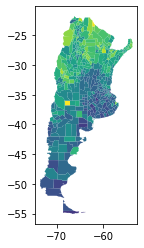

In [47]:
gdf.plot('Pobreza_mean')

In [49]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data, ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_P_FRAC.geojson')

<ipython-input-49-e3505edd1766>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Base: Personas, Mayores de 24.

In [50]:
## PROVINCIAS

df = sintetizar_P(data.loc[data.P03 >= 24], ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_M24_PROV.geojson')

<ipython-input-50-39e371c5c597>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [51]:
gdf.head(1)

,base,PROV,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_persona_mean,P47T_persona_q10,P47T_persona_q25,P47T_persona_median,P47T_persona_q75,P47T_persona_q90,geometry,area_km2
0,Personas,2,1.0,8322600.0,0.0865,719750.0,0.0204,169400.0,131570.0,25550.0,56020.0,102700.0,171780.0,270750.0,"POLYGON Z ((-58.34189 -34.63110 0.00000, -58.3...",303.401389


In [52]:
## DPTOS
df = sintetizar_P(data.loc[data.P03 >= 24], ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_M24_DPTO.geojson')

<ipython-input-52-057db84ebb05>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [53]:
gdf.head(1)

,base,DPTO,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_persona_mean,P47T_persona_q10,P47T_persona_q25,P47T_persona_median,P47T_persona_q75,P47T_persona_q90,geometry,area_km2
0,Personas,2001,1.0,604800.0,0.1295,78300.0,0.0399,24150.0,128260.0,16300.0,51100.0,101870.0,168050.0,272540.0,"POLYGON ((-58.36796 -34.62520, -58.36796 -34.6...",26.223521


In [54]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data.loc[data.P03 >= 24], ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_M24_FRAC.geojson')

<ipython-input-54-e4df9cdfd0d6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Base: Personas, Menores de 14.

In [55]:
## PROVINCIAS

df = sintetizar_P(data.loc[data.P03 <= 14], ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_M14_PROV.geojson')

<ipython-input-55-9233bdf3bae4>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [56]:
gdf.head(1)

,base,PROV,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_persona_mean,P47T_persona_q10,P47T_persona_q25,P47T_persona_median,P47T_persona_q75,P47T_persona_q90,geometry,area_km2
0,Personas,2,1.0,1938600.0,0.2548,493950.0,0.0737,142850.0,380.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-58.34189 -34.63110 0.00000, -58.3...",303.401389


In [57]:
## DPTOS
df = sintetizar_P(data.loc[data.P03 <= 14], ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_M14_DPTO.geojson')

<ipython-input-57-2d8af92a5623>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [58]:
gdf.head(1)

,base,DPTO,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_persona_mean,P47T_persona_q10,P47T_persona_q25,P47T_persona_median,P47T_persona_q75,P47T_persona_q90,geometry,area_km2
0,Personas,2001,1.0,134600.0,0.3904,52550.0,0.1415,19050.0,590.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-58.36796 -34.62520, -58.36796 -34.6...",26.223521


In [59]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data.loc[data.P03 <= 14], ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_M14_FRAC.geojson')

<ipython-input-59-ce142aad1617>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Base: Personas, Menores de 6.

In [60]:
## PROVINCIAS

df = sintetizar_P(data.loc[data.P03 <= 6], ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_M6_PROV.geojson')

<ipython-input-60-1e0c74e31f5e>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [61]:
gdf.head(1)

,base,PROV,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_persona_mean,P47T_persona_q10,P47T_persona_q25,P47T_persona_median,P47T_persona_q75,P47T_persona_q90,geometry,area_km2
0,Personas,2,1.0,966800.0,0.2359,228050.0,0.07,67650.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON Z ((-58.34189 -34.63110 0.00000, -58.3...",303.401389


In [62]:
## DPTOS
df = sintetizar_P(data.loc[data.P03 <= 6], ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_M6_DPTO.geojson')

<ipython-input-62-36f1eb72073f>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [63]:
gdf.head(1)

,base,DPTO,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_persona_mean,P47T_persona_q10,P47T_persona_q25,P47T_persona_median,P47T_persona_q75,P47T_persona_q90,geometry,area_km2
0,Personas,2001,1.0,67000.0,0.3873,25950.0,0.1448,9700.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-58.36796 -34.62520, -58.36796 -34.6...",26.223521


In [64]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_P(data.loc[data.P03 <= 6], ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_M6_FRAC.geojson')

<ipython-input-64-1c9d6e445a94>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Base: Hogares

In [65]:
## PROVINCIAS

df = sintetizar_H(data, ['PROV'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin1), crs = admin1.crs)

save_geojson(gdf, filename = 'pobreza_H_PROV.geojson')

<ipython-input-65-e44d9c5478d8>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [66]:
gdf.head(1)

,base,PROV,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_hogar_mean,P47T_hogar_q10,...,CBA_sum,CBA_median,gap_indigencia_mean,gap_indigencia_median,CBT_sum,CBT_median,gap_pobreza_mean,gap_pobreza_median,geometry,area_km2
0,Hogares,2,1.0,1158750.0,0.125,144850.0,0.0336,38900.0,215570.0,48900.0,...,848184400.0,31930.0,178970.0,134840.0,1.993243e+09,75040.0,129560.0,91620.0,"POLYGON Z ((-58.34189 -34.63110 0.00000, -58.3...",303.401389


In [71]:
## DPTOS
df = sintetizar_H(data, ['DPTO'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()
df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin210), crs = admin210.crs)

save_geojson(gdf, filename = 'pobreza_H_DPTO.geojson')

<ipython-input-71-d3f8d9dcdb61>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [72]:
gdf.head(1)

,base,DPTO,Total_mean,Total_sum,Pobreza_mean,Pobreza_sum,Indigencia_mean,Indigencia_sum,P47T_hogar_mean,P47T_hogar_q10,...,CBA_sum,CBA_median,gap_indigencia_mean,gap_indigencia_median,CBT_sum,CBT_median,gap_pobreza_mean,gap_pobreza_median,geometry,area_km2
0,Hogares,2001,1.0,88850.0,0.179,15900.0,0.054,4800.0,196090.0,40750.0,...,62609580.0,30660.0,160850.0,114300.0,147133240.0,72050.0,113290.0,73310.0,"POLYGON ((-58.36796 -34.62520, -58.36796 -34.6...",26.223521


In [73]:
## FRACS
data['IDFRAC'] = data['COD_2010'].str[:-2] + '00'
df = sintetizar_H(data, ['IDFRAC'], frac = 0.02).drop('timestamp', axis = 1)#.groupby(['observable','sintetico','base']).size()

df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
df.columns = ['_'.join(col) for col in df.columns.values]
df = df.reset_index()

gdf = gpd.GeoDataFrame(df.merge(admin310), crs = admin310.crs)

save_geojson(gdf, filename = 'pobreza_H_FRAC.geojson')

<ipython-input-73-43cd6bb7b30b>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.set_index(list(df.drop('valor', 1).columns)).unstack([0, 1])['valor']
/home/miglesia/anaconda3/lib/python3.8/site-packages/geopandas/io/file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [ ]:
## Repetir para Hogares, para M24, M14, etc.

## Atenti, mandarlo a disco duro, no a drive

In [ ]:
cd /media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data
export MAPBOX_ACCESS_TOKEN=sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMyIiwiYSI6ImNrb3lvMWZyajAxZncycG8ycnJkaTI1ZjYifQ.LXJGImmBgQtWWrNOC1wTcA

In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_H
tilesets delete-source -f matuteiglesias2 income_dptos_H
tilesets delete-source -f matuteiglesias2 income_fracs_H

tilesets delete -f matuteiglesias2.income_H

## HOGARES. 
# (REPEAT FOR PERSONAS, M24, ETC.)
tilesets upload-source matuteiglesias2 income_provs_H ./geojson/pobreza_H_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_H ./geojson/pobreza_H_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_H ./geojson/pobreza_H_FRAC.geojson

# # tilesets create username.hello-world-tiles --recipe hello-world-recipe.json --name "hello world"
tilesets create matuteiglesias2.income_H202209 --recipe ./geojson/pobreza_H-recipe.json --name "Ingresos y Pobreza - Hogares"
tilesets publish matuteiglesias2.income_H202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_P
tilesets delete-source -f matuteiglesias2 income_dptos_P
tilesets delete-source -f matuteiglesias2 income_fracs_P

tilesets delete -f matuteiglesias2.income_P

## REPEAT FOR PERSONAS
tilesets upload-source matuteiglesias2 income_provs_P ./geojson/pobreza_P_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_P ./geojson/pobreza_P_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_P ./geojson/pobreza_P_FRAC.geojson

tilesets create matuteiglesias2.income_P202209 --recipe ./geojson/pobreza_P-recipe.json --name "Ingresos y Pobreza - Personas"
tilesets publish matuteiglesias2.income_P202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_M24
tilesets delete-source -f matuteiglesias2 income_dptos_M24
tilesets delete-source -f matuteiglesias2 income_fracs_M24

tilesets delete -f matuteiglesias2.income_M24

## REPEAT FOR Mayores de 24

tilesets upload-source matuteiglesias2 income_provs_M24 ./geojson/pobreza_M24_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_M24 ./geojson/pobreza_M24_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_M24 ./geojson/pobreza_M24_FRAC.geojson

tilesets create matuteiglesias2.income_M24202209 --recipe ./geojson/pobreza_M24-recipe.json --name "Ingresos y Pobreza - Mayores de 24"
tilesets publish matuteiglesias2.income_M24202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_M14
tilesets delete-source -f matuteiglesias2 income_dptos_M14
tilesets delete-source -f matuteiglesias2 income_fracs_M14

tilesets delete -f matuteiglesias2.income_M14

## REPEAT FOR Menores de 14
tilesets upload-source matuteiglesias2 income_provs_M14 ./geojson/pobreza_M14_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_M14 ./geojson/pobreza_M14_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_M14 ./geojson/pobreza_M14_FRAC.geojson

tilesets create matuteiglesias2.income_M14202209 --recipe ./geojson/pobreza_M14-recipe.json --name "Ingresos y Pobreza - Menores de 14"
tilesets publish matuteiglesias2.income_M14202209


In [ ]:
tilesets delete-source -f matuteiglesias2 income_provs_M6
tilesets delete-source -f matuteiglesias2 income_dptos_M6
tilesets delete-source -f matuteiglesias2 income_fracs_M6

tilesets delete -f matuteiglesias2.income_M6

## REPEAT FOR Menores de 6
tilesets upload-source matuteiglesias2 income_provs_M6 ./geojson/pobreza_M6_PROV.geojson
tilesets upload-source matuteiglesias2 income_dptos_M6 ./geojson/pobreza_M6_DPTO.geojson
tilesets upload-source matuteiglesias2 income_fracs_M6 ./geojson/pobreza_M6_FRAC.geojson

tilesets create matuteiglesias2.income_M6202209 --recipe ./geojson/pobreza_M6-recipe.json --name "Ingresos y Pobreza - Menores de 6"
tilesets publish matuteiglesias2.income_M6202209


In [ ]:

# # tilesets upload-source username populated-places-source /path/to/data/populated_places.geojson.ld

# tilesets upload-source matuteiglesias2 income_provs ./geojson/pobreza_P_PROV.geojson
# tilesets upload-source matuteiglesias2 income_dptos ./geojson/pobreza_P_DPTO.geojson
# tilesets upload-source matuteiglesias2 income_fracs ./geojson/pobreza_P_FRAC.geojson


# tilesets delete-source matuteiglesias2 s


In [ ]:
# gdf = gpd.read_file('./../data/geojson/pobreza_H_PROV.geojson')
# gdf

In [ ]:
# export MAPBOX_ACCESS_TOKEN=sk.eyJ1IjoibWF0dXRlaWdsZXNpYXMyIiwiYSI6ImNrb3lvMWZyajAxZncycG8ycnJkaTI1ZjYifQ.LXJGImmBgQtWWrNOC1wTcA

# # tilesets upload-source username populated-places-source /path/to/data/populated_places.geojson.ld
# cd /media/miglesia/Elements/suite/indice-pobreza-ExactasUBA/data

# tilesets upload-source matuteiglesias2 pobreza_v2 ./geojson/pobreza_P_PROV.geojson
# tilesets upload-source matuteiglesias2 pobreza_v2 ./geojson/pobreza_P_DPTO.geojson

# # tilesets create username.hello-world-tiles --recipe hello-world-recipe.json --name "hello world"
# tilesets create matuteiglesias2.personas2 --recipe ./geojson/pobreza-recipe.json --name "Ingresos y Pobreza - Personas2"
# tilesets publish matuteiglesias2.personas2


In [ ]:
>>> import seaborn as sns
>>> pal = sns.color_palette("RdYlGn_r", 10)
>>> print(pal.as_hex())


In [ ]:
>>> import seaborn as sns
>>> pal = sns.color_palette("cool", 10)
>>> print(pal.as_hex())